In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gpjax.gps import Prior
from gpjax.likelihoods import Gaussian
from gpjax.types import Dataset
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

In [3]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
latent_f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x) + 2
signal = latent_f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = latent_f(xtest)

training = Dataset(X = x, y=y)
testing = Dataset(X = xtest, y=ytest)

In [28]:
kernel = RBF()
prior = Prior(RBF())

In [29]:
lik = Gaussian()
posterior = prior * lik

In [30]:
meanf = posterior.mean(training)
varf = posterior.variance(training)

mu = meanf(testing).ravel()
sigma = jnp.sqrt(varf(testing))

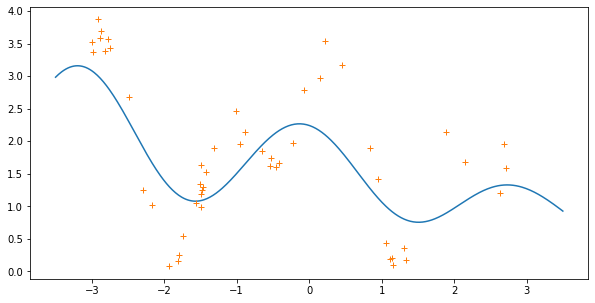

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(testing.X, mu)
ax.plot(training.X, training.y, '+')
# ax.fill_between(testing.X.ravel(), mu - sigma, mu + sigma, alpha =0.5)

In [32]:
from gpjax.objectives.mlls import negative_marginal_ll
import jax
from jax.experimental import optimizers

negative_marginal_ll(posterior, training, negative=True)

DeviceArray(71.52819358, dtype=float64)

In [33]:
from gpjax.parameters import unconstrain_parameters

unc_posterior = unconstrain_parameters(posterior)

In [34]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.1)
opt_state = opt_init(unc_posterior)

In [35]:
def step(i, opt_state):
    params = get_params(opt_state)
    v, g = jax.value_and_grad(negative_marginal_ll)(params, training)
    return opt_update(i, g, opt_state), v

In [36]:
nits = 50
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

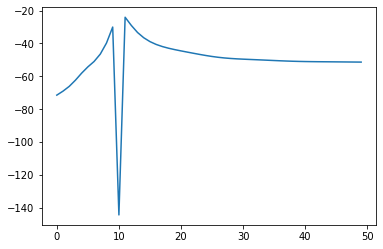

In [37]:
plt.plot(mlls)

In [38]:
fpost = get_params(opt_state)

In [39]:
fpost.likelihood.obs_noise

DeviceArray([0.48684518], dtype=float64)

In [40]:
fpost.prior.kernel.variance

DeviceArray([3.50364709], dtype=float64)

In [41]:
fpost.prior.kernel.lengthscale

DeviceArray([0.61402717], dtype=float64)